In [2]:
# Cell 1: Imports and Setup
import os
import sys
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import pennylane as qml
from torch.utils.data import DataLoader, TensorDataset

# Setup project root
PROJECT_ROOT = Path.cwd().resolve().parents[0]
sys.path.append(str(PROJECT_ROOT / "src"))

from qnn_model import QNNClassifier, Config
from data_loader import get_mnist_dataset
from quantum_attack import inject_depolarizing_noise, inject_amplitude_damping, inject_random_pauli_x_noise

# Use CPU for quantum computations (lightning.qubit is CPU-based)
device = torch.device("cpu")
print(f"🔧 Using device: {device}")

🔧 Using device: cpu


In [3]:
%matplotlib inline


In [4]:
# Cell 3: Load Trained QNN Model
cfg = Config()
model = QNNClassifier(cfg.NUM_QUBITS, cfg.NUM_CLASSES, cfg.NUM_LAYERS).to(device)
model_path = PROJECT_ROOT / "reports" / "qnn_trained_model.pt"
model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
model.eval()
print("✅ Trained QNN model loaded.")

✅ Trained QNN model loaded.


In [5]:
# Cell 4: Load Test Dataset
X_test, y_test = get_mnist_dataset(
    data_dir=PROJECT_ROOT / "datasets",
    binary_digits=tuple(range(10)),
    train=False,
    download=True,
    limit_samples=1000
)

X_test = X_test.to(device).to(torch.float64)
y_test = y_test.to(device)

In [6]:
import torch
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    cohen_kappa_score,
    matthews_corrcoef,
    top_k_accuracy_score,
    roc_auc_score,
    log_loss
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import gc

def evaluate(model, X, y, title="Evaluation", topk=3, show_confusion=True, batch_size=1):
    """
    Evaluate the QNN model on given dataset in batches and print multiple metrics.

    Args:
        model: Torch QNNClassifier.
        X: Input images [B, 1, 28, 28].
        y: True labels.
        title (str): Title to tag the evaluation.
        topk (int): Top-k value for Top-k accuracy.
        show_confusion (bool): Whether to show confusion matrix.
        batch_size (int): Batch size for processing (default: 1 for minimal memory).

    Returns:
        dict: Dictionary of all computed metrics.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    X = X.to(device).to(torch.float64)
    y = y.to(device)

    model.eval()
    all_logits = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            X_batch = X[i:i + batch_size]
            logits = model(X_batch)
            probs = torch.softmax(logits, dim=1)
            predictions = torch.argmax(probs, dim=1)
            all_logits.append(logits.cpu())
            all_probs.append(probs.cpu())
            all_predictions.append(predictions.cpu())
            del X_batch, logits, probs, predictions
            gc.collect()
            if device.type == "cuda":
                torch.cuda.empty_cache()

    logits = torch.cat(all_logits, dim=0)
    probs = torch.cat(all_probs, dim=0)
    predictions = torch.cat(all_predictions, dim=0)

    y_true = y.cpu().numpy()
    y_pred = predictions.numpy()
    y_probs = probs.numpy()

    acc = accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    topk_acc = top_k_accuracy_score(y_true, y_probs, k=topk)
    try:
        auroc = roc_auc_score(y_true, y_probs, multi_class="ovo")
    except ValueError:
        auroc = -1
    ll = log_loss(y_true, y_probs)

    print(f"\n📊 Evaluation Metrics - {title}")
    print(f"🎯 Accuracy         : {acc:.4f}")
    print(f"📘 Cohen's Kappa   : {kappa:.4f}")
    print(f"📗 MCC             : {mcc:.4f}")
    print(f"📘 Top-{topk} Acc     : {topk_acc:.4f}")
    print(f"📘 AUROC (multi)   : {auroc:.4f}")
    print(f"📕 Log Loss        : {ll:.4f}")
    print("\n[INFO] Classification Report:\n")
    print(classification_report(y_true, y_pred, digits=4))

    if show_confusion:
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
        plt.title(f"Confusion Matrix - {title}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

    del logits, probs, predictions
    gc.collect()
    if device.type == "cuda":
        torch.cuda.empty_cache()

    return {
        "accuracy": acc,
        "cohen_kappa": kappa,
        "matthews_corrcoef": mcc,
        "top{}_accuracy".format(topk): topk_acc,
        "roc_auc_score": auroc,
        "log_loss": ll,
        "y_pred": y_pred,
        "y_true": y_true,
        "probs": y_probs
    }


📊 Evaluation Metrics - Baseline QNNClassifier
🎯 Accuracy         : 0.8290
📘 Cohen's Kappa   : 0.8097
📗 MCC             : 0.8109
📘 Top-3 Acc     : 0.9340
📘 AUROC (multi)   : 0.9731
📕 Log Loss        : 0.6557

[INFO] Classification Report:

              precision    recall  f1-score   support

           0     0.8667    0.9176    0.8914        85
           1     0.9603    0.9603    0.9603       126
           2     0.8000    0.8966    0.8455       116
           3     0.8780    0.6729    0.7619       107
           4     0.9082    0.8091    0.8558       110
           5     0.6449    0.7931    0.7113        87
           6     0.8556    0.8851    0.8701        87
           7     0.8351    0.8182    0.8265        99
           8     0.8525    0.5843    0.6933        89
           9     0.7227    0.9149    0.8075        94

    accuracy                         0.8290      1000
   macro avg     0.8324    0.8252    0.8224      1000
weighted avg     0.8383    0.8290    0.8275      1000



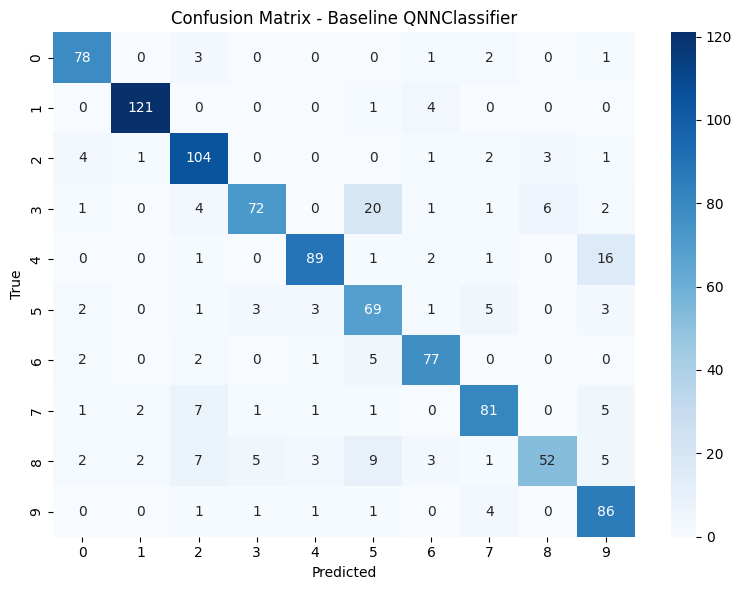

In [7]:
# Cell 6: Baseline QNNClassifier Evaluation
from qnn_model import QNNClassifier
import torch
import gc

# Instantiate and evaluate baseline model
baseline_model = QNNClassifier(
    cfg.NUM_QUBITS, cfg.NUM_CLASSES, cfg.NUM_LAYERS
).to(device)
baseline_model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
baseline_model.eval()

results_baseline = evaluate(
    baseline_model, X_test, y_test, title="Baseline QNNClassifier", batch_size=16
)
preds_baseline = results_baseline["y_pred"]


📊 Evaluation Metrics - Depolarizing Noise Attack (Kraus)
🎯 Accuracy         : 0.1190
📘 Cohen's Kappa   : 0.0199
📗 MCC             : 0.0200
📘 Top-3 Acc     : 0.3290
📘 AUROC (multi)   : 0.5184
📕 Log Loss        : 13.7727

[INFO] Classification Report:

              precision    recall  f1-score   support

           0     0.0811    0.0353    0.0492        85
           1     0.0984    0.0952    0.0968       126
           2     0.1161    0.1121    0.1140       116
           3     0.1360    0.1589    0.1466       107
           4     0.1940    0.1182    0.1469       110
           5     0.0932    0.1724    0.1210        87
           6     0.0959    0.0805    0.0875        87
           7     0.1230    0.1515    0.1357        99
           8     0.1053    0.1348    0.1182        89
           9     0.1791    0.1277    0.1491        94

    accuracy                         0.1190      1000
   macro avg     0.1222    0.1187    0.1165      1000
weighted avg     0.1235    0.1190    0.1176 

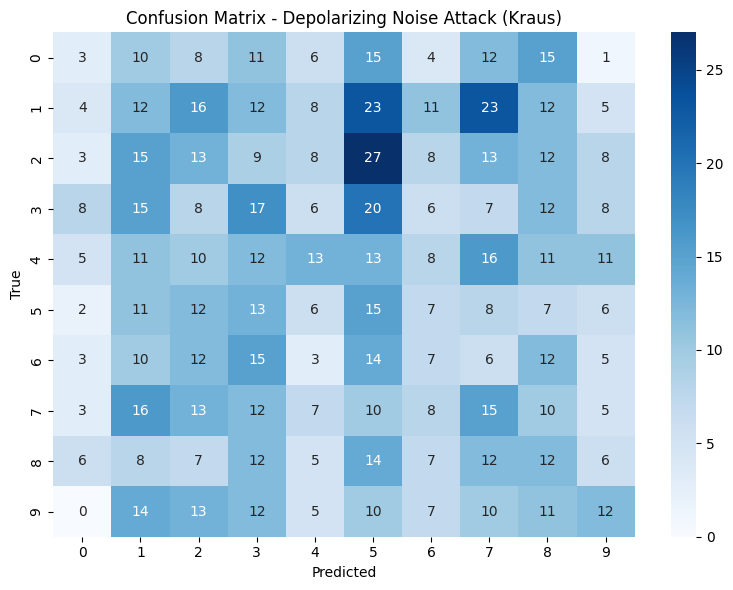

In [8]:
from qnn_model import QNNClassifier
import pennylane as qml
import torch
import gc
import numpy as np

# Custom depolarizing noise via Kraus operators
def kraus_depolarizing_noise(wires, prob=0.01, shots=10):
    def noise_fn(wires, prob):
        for w in wires:
            r = np.random.random()
            p = prob / 4
            if r < p:
                qml.PauliX(wires=w)
            elif r < 2 * p:
                qml.PauliY(wires=w)
            elif r < 3 * p:
                qml.PauliZ(wires=w)
            # Else identity (probability 1 - 3p/4)
    return noise_fn

class NoisyQNNClassifier(QNNClassifier):
    def __init__(self, num_qubits, num_classes, num_layers, noise_fn=None, noise_params=None):
        super().__init__(num_qubits, num_classes, num_layers)
        self.noise_fn = noise_fn
        self.noise_params = noise_params
        self.num_qubits = num_qubits

        @qml.qnode(
            qml.device("default.qubit", wires=num_qubits, shots=10),  # 10 shots for noise averaging
            interface="torch",
            diff_method="parameter-shift",  # Changed from adjoint
            cachesize=1000
        )
        def noisy_qnode(inputs, weights):
            qml.AngleEmbedding(inputs, wires=range(num_qubits), rotation='Y')
            qml.templates.BasicEntanglerLayers(weights, wires=range(num_qubits))
            if self.noise_fn is not None:
                self.noise_fn(wires=range(num_qubits//2), **self.noise_params)
            return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

        weight_shapes = {"weights": (num_layers, num_qubits)}
        self.qlayer = qml.qnn.TorchLayer(noisy_qnode, weight_shapes)

    def forward(self, x):
        x = x.float()
        x = self.classical_preprocess(x)
        x = x.double()
        quantum_output = self.qlayer(x)
        quantum_output = quantum_output.float().to(next(self.model.parameters()).device)
        del x
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        return self.model(quantum_output)

# Apply Depolarizing Noise
noise_prob = 0.05
noisy_model = NoisyQNNClassifier(
    cfg.NUM_QUBITS, cfg.NUM_CLASSES, cfg.NUM_LAYERS,
    noise_fn=kraus_depolarizing_noise(wires=range(cfg.NUM_QUBITS//2), prob=noise_prob, shots=10),
    noise_params={"prob": noise_prob}
).to(device)
noisy_model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
noisy_model.eval()

results_depolarizing = evaluate(
    noisy_model, X_test, y_test, title="Depolarizing Noise Attack (Kraus)", batch_size=16
)
preds_depolarizing = results_depolarizing["y_pred"]


📊 Evaluation Metrics - Amplitude Damping Attack (Kraus)
🎯 Accuracy         : 0.1030
📘 Cohen's Kappa   : 0.0017
📗 MCC             : 0.0018
📘 Top-3 Acc     : 0.3070
📘 AUROC (multi)   : 0.5021
📕 Log Loss        : 14.0474

[INFO] Classification Report:

              precision    recall  f1-score   support

           0     0.1429    0.0941    0.1135        85
           1     0.1154    0.0952    0.1043       126
           2     0.1690    0.2069    0.1860       116
           3     0.0746    0.0935    0.0830       107
           4     0.1081    0.0727    0.0870       110
           5     0.0580    0.0920    0.0711        87
           6     0.0779    0.0690    0.0732        87
           7     0.1130    0.1313    0.1215        99
           8     0.0680    0.0787    0.0729        89
           9     0.1228    0.0745    0.0927        94

    accuracy                         0.1030      1000
   macro avg     0.1050    0.1008    0.1005      1000
weighted avg     0.1068    0.1030    0.1026  

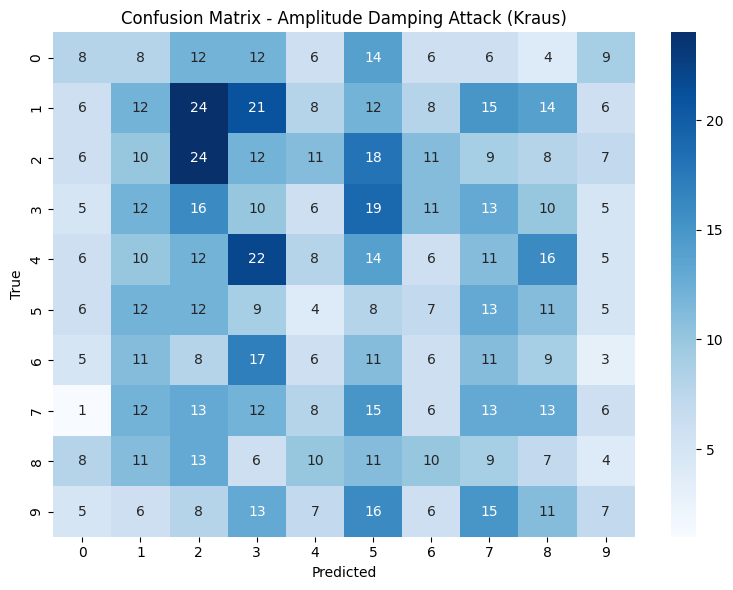

In [9]:
from qnn_model import QNNClassifier
import pennylane as qml
import torch
import gc
import numpy as np

# Custom amplitude damping via Kraus operators
def kraus_amplitude_damping(wires, gamma=0.02, shots=10):
    def noise_fn(wires, gamma):
        for w in wires:
            r = np.random.random()
            if r < gamma:
                qml.PauliX(wires=w)  # Approximate K_1 effect
            # Else identity (K_0, probability 1-gamma)
    return noise_fn

class NoisyQNNClassifier(QNNClassifier):
    def __init__(self, num_qubits, num_classes, num_layers, noise_fn=None, noise_params=None):
        super().__init__(num_qubits, num_classes, num_layers)
        self.noise_fn = noise_fn
        self.noise_params = noise_params
        self.num_qubits = num_qubits

        @qml.qnode(
            qml.device("default.qubit", wires=num_qubits, shots=10),
            interface="torch",
            diff_method="parameter-shift",
            cachesize=1000
        )
        def noisy_qnode(inputs, weights):
            qml.AngleEmbedding(inputs, wires=range(num_qubits), rotation='Y')
            qml.templates.BasicEntanglerLayers(weights, wires=range(num_qubits))
            if self.noise_fn is not None:
                self.noise_fn(wires=range(num_qubits//2), **self.noise_params)
            return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

        weight_shapes = {"weights": (num_layers, num_qubits)}
        self.qlayer = qml.qnn.TorchLayer(noisy_qnode, weight_shapes)

    def forward(self, x):
        x = x.float()
        x = self.classical_preprocess(x)
        x = x.double()
        quantum_output = self.qlayer(x)
        quantum_output = quantum_output.float().to(next(self.model.parameters()).device)
        del x
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        return self.model(quantum_output)

# Apply Amplitude Damping
gamma = 0.1
noisy_model = NoisyQNNClassifier(
    cfg.NUM_QUBITS, cfg.NUM_CLASSES, cfg.NUM_LAYERS,
    noise_fn=kraus_amplitude_damping(wires=range(cfg.NUM_QUBITS//2), gamma=gamma, shots=10),
    noise_params={"gamma": gamma}
).to(device)
noisy_model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
noisy_model.eval()

results_amplitude = evaluate(
    noisy_model, X_test, y_test, title="Amplitude Damping Attack (Kraus)", batch_size=16
)
preds_amplitude = results_amplitude["y_pred"]


📊 Evaluation Metrics - Random Pauli-X Noise Attack
🎯 Accuracy         : 0.1090
📘 Cohen's Kappa   : 0.0090
📗 MCC             : 0.0090
📘 Top-3 Acc     : 0.3080
📘 AUROC (multi)   : 0.5009
📕 Log Loss        : 13.9764

[INFO] Classification Report:

              precision    recall  f1-score   support

           0     0.1636    0.1059    0.1286        85
           1     0.1240    0.1190    0.1215       126
           2     0.1186    0.1207    0.1197       116
           3     0.1364    0.1402    0.1382       107
           4     0.0959    0.0636    0.0765       110
           5     0.1000    0.1724    0.1266        87
           6     0.0632    0.0690    0.0659        87
           7     0.1062    0.1212    0.1132        99
           8     0.0909    0.1011    0.0957        89
           9     0.1061    0.0745    0.0875        94

    accuracy                         0.1090      1000
   macro avg     0.1105    0.1088    0.1073      1000
weighted avg     0.1112    0.1090    0.1080      1

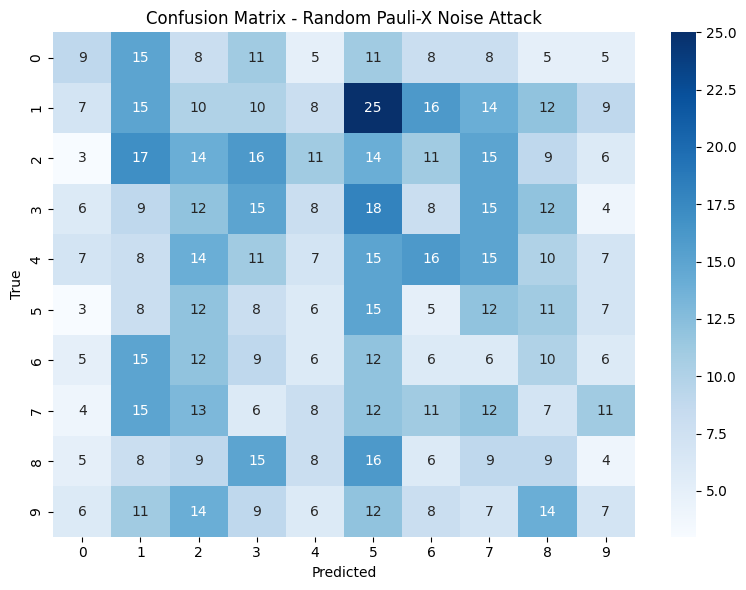

In [10]:
from qnn_model import QNNClassifier
import pennylane as qml
import torch
import gc
import numpy as np

# Random Pauli-X noise
def random_pauli_x_noise(wires, prob=0.05, shots=10):
    def noise_fn(wires, prob):
        inject_random_pauli_x_noise(wires, prob=prob)
    return noise_fn

class NoisyQNNClassifier(QNNClassifier):
    def __init__(self, num_qubits, num_classes, num_layers, noise_fn=None, noise_params=None):
        super().__init__(num_qubits, num_classes, num_layers)
        self.noise_fn = noise_fn
        self.noise_params = noise_params
        self.num_qubits = num_qubits

        @qml.qnode(
            qml.device("lightning.qubit", wires=num_qubits, shots=10),
            interface="torch",
            diff_method="parameter-shift",
            cachesize=1000
        )
        def noisy_qnode(inputs, weights):
            qml.AngleEmbedding(inputs, wires=range(num_qubits), rotation='Y')
            qml.templates.BasicEntanglerLayers(weights, wires=range(num_qubits))
            if self.noise_fn is not None:
                self.noise_fn(wires=range(num_qubits//2), **self.noise_params)
            return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

        weight_shapes = {"weights": (num_layers, num_qubits)}
        self.qlayer = qml.qnn.TorchLayer(noisy_qnode, weight_shapes)

    def forward(self, x):
        x = x.float()
        x = self.classical_preprocess(x)
        x = x.double()
        quantum_output = self.qlayer(x)
        quantum_output = quantum_output.float().to(next(self.model.parameters()).device)
        del x
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        return self.model(quantum_output)

# Apply Random Pauli-X Noise
prob = 0.05
noisy_model = NoisyQNNClassifier(
    cfg.NUM_QUBITS, cfg.NUM_CLASSES, cfg.NUM_LAYERS,
    noise_fn=random_pauli_x_noise(
        wires=range(cfg.NUM_QUBITS//2), prob=prob, shots=10
    ),
    noise_params={"prob": prob}
).to(device)
noisy_model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
noisy_model.eval()

results_pauli_x = evaluate(
    noisy_model, X_test, y_test, title="Random Pauli-X Noise Attack", batch_size=16
)
preds_pauli_x = results_pauli_x["y_pred"]

In [12]:
# List of result dictionaries and their titles
results_list = [
    (results_baseline, "Baseline QNNClassifier"),
    (results_depolarizing, "Depolarizing Noise Attack (Kraus)"),
    (results_amplitude, "Amplitude Damping Attack (Kraus)"),
    (results_pauli_x,"Random Pauli-X Noise Attack")
]

# Display metrics for each model
for results, title in results_list:
    print(f"\n📊 Evaluation Metrics - {title}")
    print(f"🎯 Accuracy         : {results['accuracy']:.4f}")
    print(f"📘 Cohen's Kappa   : {results['cohen_kappa']:.4f}")
    print(f"📗 MCC             : {results['matthews_corrcoef']:.4f}")
    print(f"📘 Top-3 Acc       : {results['top3_accuracy']:.4f}")
    print(f"📘 AUROC (multi)   : {results['roc_auc_score']:.4f}")
    print(f"📕 Log Loss        : {results['log_loss']:.4f}")



📊 Evaluation Metrics - Baseline QNNClassifier
🎯 Accuracy         : 0.8290
📘 Cohen's Kappa   : 0.8097
📗 MCC             : 0.8109
📘 Top-3 Acc       : 0.9340
📘 AUROC (multi)   : 0.9731
📕 Log Loss        : 0.6557

📊 Evaluation Metrics - Depolarizing Noise Attack (Kraus)
🎯 Accuracy         : 0.1190
📘 Cohen's Kappa   : 0.0199
📗 MCC             : 0.0200
📘 Top-3 Acc       : 0.3290
📘 AUROC (multi)   : 0.5184
📕 Log Loss        : 13.7727

📊 Evaluation Metrics - Amplitude Damping Attack (Kraus)
🎯 Accuracy         : 0.1030
📘 Cohen's Kappa   : 0.0017
📗 MCC             : 0.0018
📘 Top-3 Acc       : 0.3070
📘 AUROC (multi)   : 0.5021
📕 Log Loss        : 14.0474

📊 Evaluation Metrics - Random Pauli-X Noise Attack
🎯 Accuracy         : 0.1090
📘 Cohen's Kappa   : 0.0090
📗 MCC             : 0.0090
📘 Top-3 Acc       : 0.3080
📘 AUROC (multi)   : 0.5009
📕 Log Loss        : 13.9764
